## Train ST-GNN models
- GCN-LSTM
- GAT-LSTM
- etc.

X: shape (n_time, n_tmc, n_features)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import networkx as nx
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
# Data validation: ensure MultiIndex with ['tmc_code','time_bin']
if not isinstance(X_full.index, pd.MultiIndex):
    raise ValueError('Expected MultiIndex (tmc_code, time_bin). Got single Index.')
expected_levels = {'tmc_code','time_bin'}
if set(X_full.index.names) != expected_levels:
    raise ValueError(f'Index level names mismatch. Found {X_full.index.names}')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))
print('Index names:', X_full.index.names)
print('Columns sample:', X_full.columns[:10])

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 27)
Index names: ['tmc_code', 'time_bin']
Columns sample: Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp',
       'onramp'],
      dtype='object')


In [3]:
tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}

In [4]:
# Build graph
def build_highway_graphs(tmc_order_dict):
    """
    Build separate line graphs for each travel direction.
    
    Args:
        tmc_order_dict: dict with direction name -> ordered list of TMC codes
                        e.g., {'NB': ['115+04177', '115+04178', ...],
                               'SB': ['115-04177', '115-04178', ...]}
    Returns:
        edge_index_dict: dict with same keys, each value = edge_index tensor (2 x E_dir)
        node_id_dict: dict mapping direction -> {tmc_code: node_id_within_dir}
    """
    edge_index_dict = {}
    node_id_dict = {}

    for direction, tmc_list in tmc_order_dict.items():
        G = nx.Graph()
        for i in range(len(tmc_list) - 1):
            G.add_edge(i, i + 1)
        edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
        edge_index_dict[direction] = edge_index
        node_id_dict[direction] = {tmc: i for i, tmc in enumerate(tmc_list)}

    return edge_index_dict, node_id_dict


def dataframe_to_tensors_by_direction(X_full, feature_cols, target_col, tmc_order_dict):
    """
    Convert a multi-indexed DataFrame (tmc_code, time_bin) into
    per-direction tensors for spatio-temporal GNN training.

    Args:
        X_full : DataFrame with MultiIndex ['tmc_code', 'time_bin']
        feature_cols : list of feature column names
        target_col : target column name (e.g. 'tt_per_mile')
        tmc_order_dict : dict of direction -> ordered list of TMCs
    
    Returns:
        tensors_dict : {
            direction: {
                'X': [T, N, F] tensor,
                'Y': [T, N] tensor,
                'tmc_order': list of TMCs,
                'time_index': list of time bins
            }, ...
        }
    """
    X_full = X_full.sort_index(level=['time_bin', 'tmc_code'])
    time_index = X_full.index.get_level_values('time_bin').unique().tolist()
    T = len(time_index)
    F = len(feature_cols)

    tensors_dict = {}

    for direction, tmc_order_list in tmc_order_dict.items():
        N = len(tmc_order_list)
        X = np.zeros((T, N, F), dtype=np.float32)
        Y = np.zeros((T, N), dtype=np.float32)

        for ti, t in enumerate(time_index):
            df_t = X_full.xs(t, level='time_bin').reindex(tmc_order_list)
            X[ti] = df_t[feature_cols].to_numpy()
            Y[ti] = df_t[target_col].to_numpy()

        tensors_dict[direction] = {
            'X': torch.tensor(X),
            'Y': torch.tensor(Y),
            'tmc_order': tmc_order_list,
            'time_index': time_index
        }

    return tensors_dict

def build_pyg_data_dict(tensors_dict, edge_index_dict):
    """
    Wrap per-direction tensors and graph edges into PyG Data objects.
    
    Args:
        tensors_dict: output of dataframe_to_tensors_by_direction()
        edge_index_dict: output of build_highway_graphs()
    
    Returns:
        data_dict: dict(direction -> PyG Data)
    """
    data_dict = {}
    for direction in tensors_dict.keys():
        X = tensors_dict[direction]['X']     # [T, N, F]
        Y = tensors_dict[direction]['Y']     # [T, N]
        edge_index = edge_index_dict[direction]  # [2, E]

        # We’ll store temporal tensors directly in the object for convenience.
        data = Data(edge_index=edge_index)
        data.X = X
        data.Y = Y
        data.tmc_order = tensors_dict[direction]['tmc_order']
        data.time_index = tensors_dict[direction]['time_index']
        data_dict[direction] = data

    return data_dict

⚠️ For a production implementation, you’ll want to vectorize the GCN across time more efficiently (e.g., with batch-wise edge replication), but this version is conceptually clear.

In [5]:
class LogSpaceMSE(nn.Module):
    def forward(self, y_true, y_pred):
        eps = 1e-6
        y_true = torch.clamp(y_true, min=eps)
        y_pred = torch.clamp(y_pred, min=eps)
        return ((torch.log(y_true) - torch.log(y_pred))**2).mean()
    
class GCN_LSTM(nn.Module):
    def __init__(self, in_features, gcn_hidden, lstm_hidden, out_features, edge_index, dropout=0.2):
        super().__init__()
        self.register_buffer('edge_index', edge_index)

        # --- Input normalization layer (acts like Keras Normalization)
        self.input_norm = nn.BatchNorm1d(in_features, affine=False, track_running_stats=True)

        # --- Spatial and temporal blocks
        self.gcn = GCNConv(in_features, gcn_hidden)
        self.bn_gcn = nn.BatchNorm1d(gcn_hidden)   # stabilize GCN output
        self.lstm = nn.LSTM(gcn_hidden, lstm_hidden, batch_first=True)

        # --- Head
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden, 32)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(32, out_features)

    def _build_batched_edge_index(self, B, N):
        base = self.edge_index
        E = base.size(1)
        offsets = torch.arange(B, device=base.device).view(-1, 1, 1) * N
        ei = base.view(1, 2, E) + offsets
        ei = ei.permute(1, 0, 2).reshape(2, B * E)
        return ei

    def forward(self, X_seq):
        # X_seq: [B, T, N, F]
        B, T, N, F = X_seq.shape
        batched_edge_index = self._build_batched_edge_index(B, N)
        spatial_out = []

        # --- Normalize inputs feature-wise before GCN (like StandardScaler)
        # Flatten across batch, time, nodes → apply BN on feature dimension
        X_seq_flat = X_seq.reshape(-1, F)
        X_seq_flat = self.input_norm(X_seq_flat)
        X_seq = X_seq_flat.view(B, T, N, F)

        for t in range(T):
            x_t = X_seq[:, t].reshape(B * N, F)
            g = self.gcn(x_t, batched_edge_index)
            g = self.bn_gcn(g)
            g = torch.relu(g).view(B, N, -1)
            spatial_out.append(g)

        H = torch.stack(spatial_out, dim=1)  # [B, T, N, gcn_hidden]
        H = H.permute(0, 2, 1, 3).reshape(B * N, T, -1)
        lstm_out, _ = self.lstm(H)
        last = self.dropout(lstm_out[:, -1])
        pred = self.fc2(self.act(self.fc1(last))).view(B, N, -1)
        return pred

def train_gcn_lstm(model, data, seq_len=6, epochs=100, lr=1e-3,
                      batch_size=128, val_frac=0.1, clip=1.0,
                      patience_limit=10, device='cpu'):
    """
    Trains a GCN-LSTM model with in-model normalization (no external scaler).

    Args:
        model : nn.Module (GCN_LSTM_v4)
        data : PyG Data object with .X [T,N,F], .Y [T,N]
        seq_len : lookback window
        val_frac : fraction of train set for validation
        patience_limit : early stopping patience
    """

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    X = data.X.to(device)   # [T, N, F]
    Y = data.Y.to(device)   # [T, N]
    T_total = X.size(0)
    n_train = int(T_total * (1 - val_frac))

    # --- Build sliding windows ---
    def make_windows(X_tensor, Y_tensor):
        X_list, Y_list = [], []
        for t in range(seq_len, X_tensor.size(0)):
            X_list.append(X_tensor[t - seq_len:t].unsqueeze(0))
            Y_list.append(Y_tensor[t].unsqueeze(0).unsqueeze(-1))
        return torch.cat(X_list), torch.cat(Y_list)

    X_train, Y_train = make_windows(X[:n_train], Y[:n_train])
    X_val, Y_val     = make_windows(X[n_train - seq_len:], Y[n_train - seq_len:])

    # --- DataLoaders (shuffle training) ---
    train_ds = TensorDataset(X_train, Y_train)
    val_ds   = TensorDataset(X_val, Y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_val = float('inf')
    patience = 0
    best_state = None

    print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

    for epoch in range(epochs):
        # ----- TRAIN -----
        model.train()  # enables BatchNorm & Dropout updates
        total_loss = 0.0

        for Xb, Yb in train_loader:
            optimizer.zero_grad()
            preds = model(Xb)
            loss = loss_fn(preds, Yb)
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item() * Xb.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # ----- VALIDATION -----
        model.eval()   # freeze BN statistics (no running mean updates)
        val_loss = 0.0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                preds = model(Xb)
                val_loss += loss_fn(preds, Yb).item() * Xb.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f} | Val {val_loss:.4f}")

        # ----- Early stopping -----
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
            if patience >= patience_limit:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return model

def predict_sequence(model, data, seq_len=6, horizon=1, device='cpu'):
    model.eval()
    X = data.X.to(device)
    T = X.size(0)
    preds = []
    with torch.no_grad():
        for t in range(seq_len, T - horizon + 1):
            x_seq = X[t-seq_len:t].unsqueeze(0)
            y_hat = model(x_seq).squeeze(0)  # [N, out_features]
            preds.append(y_hat.cpu())
    return torch.stack(preds)  # [T-seq_len-horizon+1, N, out_features]

In [9]:
# Build tensors and graphs (from previous steps)
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_unplanned', 'evt_cat_planned']
# lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
lag_features = ['lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + lag_features + tmc_features

FEATURE_COLS = full_features
TARGET_COL = 'tt_per_mile'
SEQ_LEN = 24

edge_index_dict, node_id_dict = build_highway_graphs(tmc_order_dict)
tensors_dict = dataframe_to_tensors_by_direction(X_full, FEATURE_COLS, TARGET_COL, tmc_order_dict)
data_dict = build_pyg_data_dict(tensors_dict, edge_index_dict)

# Pick one direction to train 
data = data_dict['WB']
edge_index = edge_index_dict['WB']

# Initialize model
in_features = data.X.shape[-1]
model = GCN_LSTM(in_features=in_features, gcn_hidden=64, lstm_hidden=128, out_features=1, edge_index=edge_index)

# Train
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model = train_gcn_lstm(model, data, seq_len=SEQ_LEN, epochs=100, batch_size=128, lr=1e-3, device=device)

Training samples: 2112, Validation samples: 238
Epoch 1/100 | Train 2672.9927 | Val 2813.0663
Epoch 2/100 | Train 2158.7810 | Val 2243.5189
Epoch 3/100 | Train 1624.9799 | Val 1723.7687
Epoch 4/100 | Train 1147.2435 | Val 1247.8757
Epoch 5/100 | Train 720.4033 | Val 831.8899
Epoch 6/100 | Train 371.1590 | Val 508.0449
Epoch 7/100 | Train 134.8132 | Val 317.2514
Epoch 8/100 | Train 53.5131 | Val 288.6466
Epoch 9/100 | Train 49.9954 | Val 290.7403
Epoch 10/100 | Train 49.3841 | Val 290.1652
Epoch 11/100 | Train 49.2397 | Val 289.3337
Epoch 12/100 | Train 47.1555 | Val 277.5971
Epoch 13/100 | Train 44.5041 | Val 266.9379
Epoch 14/100 | Train 43.2088 | Val 263.5526
Epoch 15/100 | Train 42.3011 | Val 254.0293
Epoch 16/100 | Train 40.7042 | Val 253.9295
Epoch 17/100 | Train 40.6873 | Val 253.7047
Epoch 18/100 | Train 40.5901 | Val 251.5118
Epoch 19/100 | Train 39.9130 | Val 257.5788
Epoch 20/100 | Train 39.8768 | Val 259.5719
Epoch 21/100 | Train 39.6570 | Val 262.1475
Epoch 22/100 | Train 3

In [10]:
# evaluate & visualize (updated)
def make_eval_df(preds, data, seq_len):
    """
    Convert model predictions and true Y into a long DataFrame with time/TMC context.
    Args:
        preds: torch.Tensor [T_pred, N]
        data:  PyG Data with attributes time_index, tmc_order, Y
    """
    preds_np = preds.cpu().numpy()
    y_true_np = data.Y[seq_len:seq_len + preds_np.shape[0]].cpu().numpy()

    time_bins = data.time_index[seq_len:seq_len + preds_np.shape[0]]
    tmcs = data.tmc_order

    # Build DataFrame
    df_pred = pd.DataFrame(
        preds_np,
        index=pd.Index(time_bins, name="time_bin"),
        columns=tmcs
    ).melt(ignore_index=False, var_name="tmc_code", value_name="y_pred").reset_index()

    df_true = pd.DataFrame(
        y_true_np,
        index=pd.Index(time_bins, name="time_bin"),
        columns=tmcs
    ).melt(ignore_index=False, var_name="tmc_code", value_name="y_true").reset_index()

    # Merge true + pred
    df = pd.merge(df_true, df_pred, on=["time_bin", "tmc_code"], how="left")
    return df

preds = predict_sequence(model, data, seq_len=SEQ_LEN, device=device).squeeze(-1)  # [T_eval, N]
eval_df = make_eval_df(preds, data, SEQ_LEN)
print(eval_df.head())

                   time_bin   tmc_code     y_true     y_pred
0 2025-06-17 03:00:00+00:00  115P04188  51.471672  51.372158
1 2025-06-17 04:00:00+00:00  115P04188  50.819965  52.063015
2 2025-06-17 05:00:00+00:00  115P04188  51.642353  53.634182
3 2025-06-17 06:00:00+00:00  115P04188  53.136196  57.869953
4 2025-06-17 07:00:00+00:00  115P04188  88.829674  77.685638


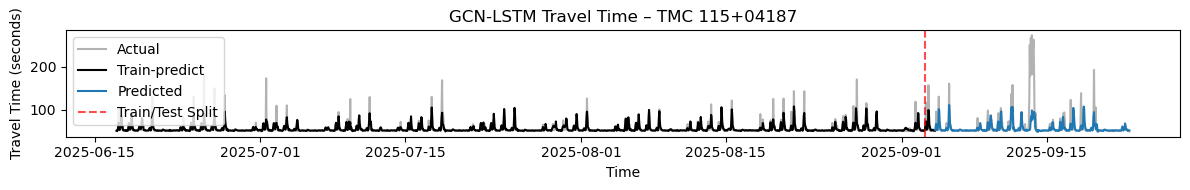

In [15]:
TMC = '115+04187'

tmc_df = eval_df.query("tmc_code == @TMC").sort_values("time_bin")
n_train = int(len(data.time_index) * 0.8)
split_time = data.time_index[n_train]

plt.figure(figsize=(12, 2))
plt.plot(tmc_df["time_bin"], tmc_df["y_true"], label="Actual", color="gray", alpha=0.6)
# plt.plot(tmc_df["time_bin"], tmc_df["y_pred"], label="Predicted", color="orange")
plt.plot(tmc_df["time_bin"][:n_train], tmc_df["y_pred"][:n_train], label='Train-predict', color='black')
plt.plot(tmc_df["time_bin"][n_train:], tmc_df["y_pred"][n_train:], label='Predicted')
plt.axvline(x=split_time, color="red", linestyle="--", alpha=0.7, label="Train/Test Split")
plt.title(f"GCN-LSTM Travel Time – TMC {TMC}")
plt.xlabel("Time")
plt.ylabel("Travel Time (seconds)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:

import seaborn as sns

def plot_travel_time_heatmap_simple(
    source,
    preds=None,                 # torch.Tensor [T, N] or np.array
    seq_len=0,                  # prediction offset
    field='y_true',             # 'y_true' or 'y_pred'
    cmap='viridis',
    vmin=40, vmax=110,
    agg='mean'
):
    """
    Plot a spatio-temporal heatmap of travel time (actual or predicted)
    directly from a `data` object or an `X_full` DataFrame.

    Args:
        source : PyG Data (with .Y, .tmc_order, .time_index) or X_full DataFrame
        preds  : Optional prediction array [T, N]; if given, field='y_pred' uses this
        seq_len: Offset between Y and preds (same as training seq_len)
        field  : 'y_true' or 'y_pred'
    """
    # ---- Build tidy DataFrame ----
    if isinstance(source, pd.DataFrame):
        # from X_full (MultiIndex: tmc_code, time_bin)
        X_full = source.sort_index(level=['time_bin', 'tmc_code'])
        time_index = X_full.index.get_level_values('time_bin').unique()
        tmc_order = X_full.index.get_level_values('tmc_code').unique()
        Y = (
            X_full.reset_index()[['time_bin', 'tmc_code', 'tt_per_mile']]
            .pivot(index='time_bin', columns='tmc_code', values='tt_per_mile')
            .reindex(index=time_index, columns=tmc_order)
        )
        Y_np = Y.to_numpy()
    else:
        # from PyG Data
        data = source
        time_index = data.time_index
        tmc_order = data.tmc_order
        Y_np = data.Y.cpu().numpy()

    # Align predictions if provided
    if preds is not None and field == 'y_pred':
        preds_np = preds.detach().cpu().numpy() if hasattr(preds, "detach") else np.array(preds)
        time_index = time_index[seq_len:seq_len + preds_np.shape[0]]
        Z = preds_np
        title = "Predicted Travel Time"
    else:
        Z = Y_np
        title = "Actual Travel Time"

    # ---- Build DataFrame for plotting ----
    df_heat = pd.DataFrame(Z, index=time_index, columns=tmc_order)

    # Optional aggregation (e.g., resample hourly)
    if isinstance(df_heat.index, pd.DatetimeIndex):
        df_heat = df_heat.resample('1h').agg(agg)

    # ---- Plot heatmap ----
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(
        df_heat.T,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Travel Time (sec/mile)'},
        mask=df_heat.T.isna()
    )
    plt.title(f"{title} Heatmap — {len(time_index)} timesteps × {len(tmc_order)} segments")
    plt.xlabel("Time")
    plt.ylabel("TMC (ordered index)")

    # --- Trim x-axis labels (drop last 10 chars) ---
    xticklabels = [label.get_text()[:-13] for label in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels, rotation=90, ha='center')
    
    plt.tight_layout()
    plt.show()

    return df_heat

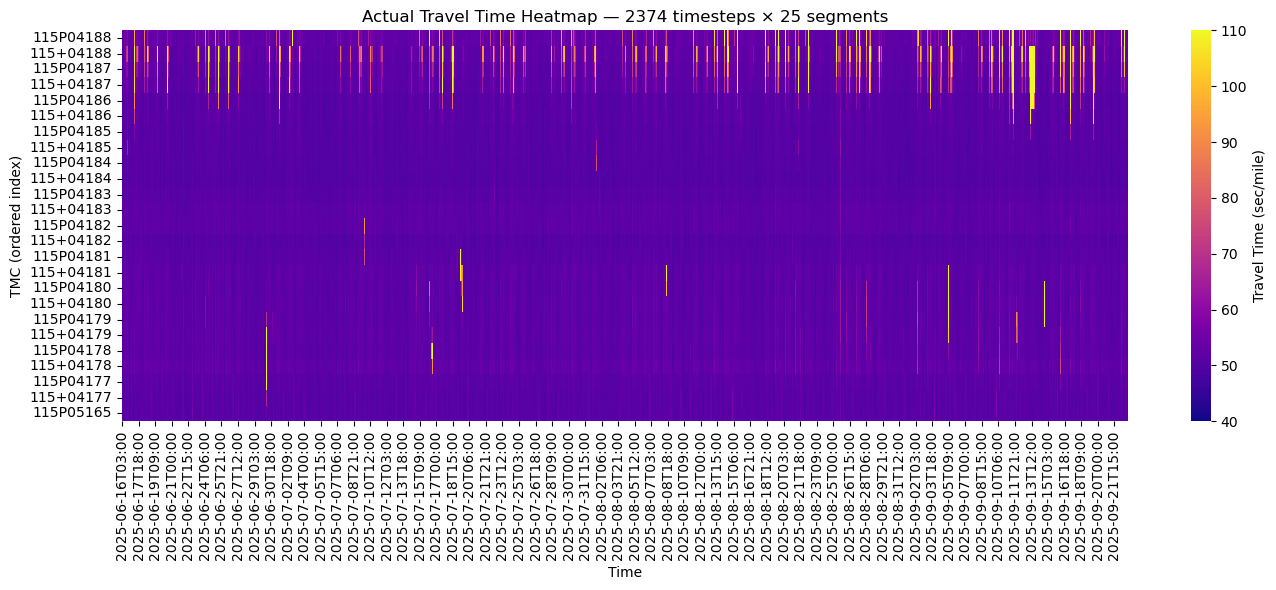

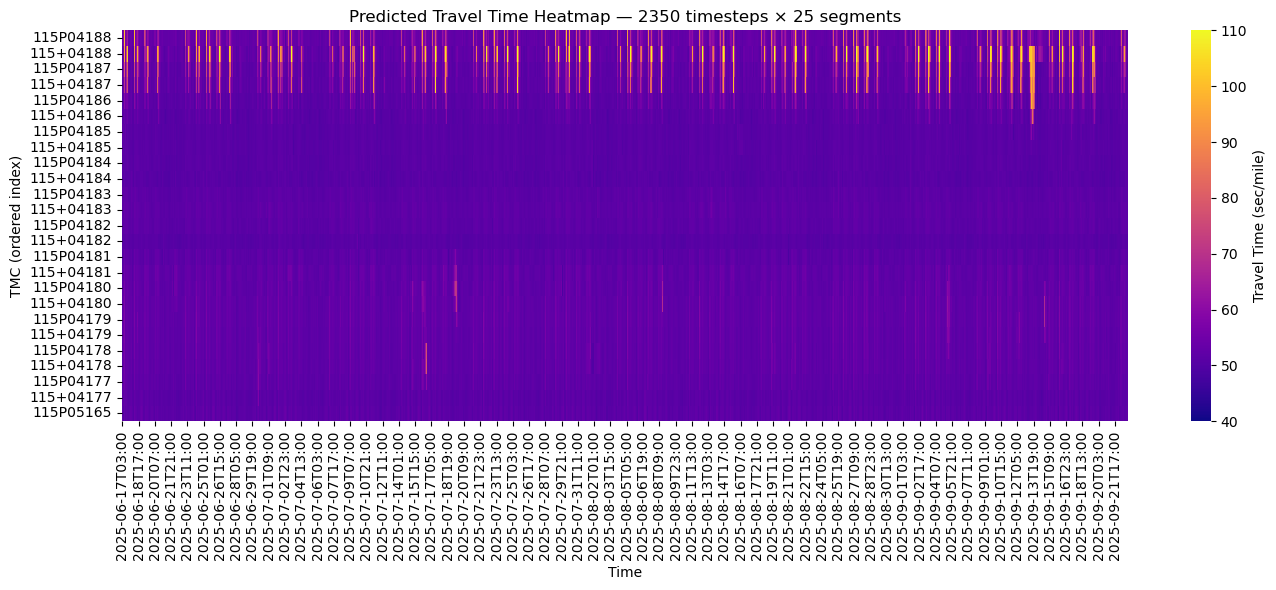

,115P04188,115+04188,115P04187,115+04187,115P04186,115+04186,115P04185,115+04185,115P04184,115+04184,...,115+04181,115P04180,115+04180,115P04179,115+04179,115P04178,115+04178,115P04177,115+04177,115P05165
2025-06-17 03:00:00+00:00,51.372158,50.178555,50.858109,50.614155,50.685314,51.041157,50.835430,50.974468,51.207901,51.268223,...,51.375362,51.677185,51.475723,51.525536,51.556198,51.302326,50.848392,50.674351,51.505093,51.747677
2025-06-17 04:00:00+00:00,52.063015,49.428883,50.214741,50.072392,49.824837,50.316925,51.262684,51.017841,50.729244,50.504543,...,50.583736,51.101360,50.810108,50.868816,50.770145,50.477230,50.133991,50.135761,50.991718,51.345661
2025-06-17 05:00:00+00:00,53.634182,49.736389,51.185455,50.553066,49.375721,50.227818,49.847618,49.814930,50.936710,50.155186,...,50.791599,50.872929,51.388527,51.638721,51.329487,51.062870,50.571136,50.881943,50.642792,49.752880
2025-06-17 06:00:00+00:00,57.869953,54.616501,57.381931,53.978222,50.940151,51.162704,51.864338,51.493122,51.188618,50.312057,...,51.384518,52.442593,53.355961,53.835262,53.847614,53.626369,52.680695,52.901722,51.247486,50.079464
2025-06-17 07:00:00+00:00,77.685638,73.708046,70.499573,61.689327,55.174381,52.674221,51.811710,51.469265,51.229748,50.759769,...,53.457359,55.711979,56.350536,56.357014,56.621601,56.269306,55.005367,54.687885,52.604992,51.878422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22 20:00:00+00:00,51.842468,52.698063,52.465099,50.939674,51.576534,51.288067,50.978382,51.224171,51.373764,51.363842,...,52.155327,51.983932,51.939709,52.051044,52.039028,52.009884,52.023312,51.812279,51.213398,51.864109
2025-09-22 21:00:00+00:00,52.373730,52.677982,51.245548,50.369831,51.422916,50.668259,50.667221,51.039051,51.130802,51.237236,...,51.696423,51.695843,51.938515,52.012077,51.852623,51.913750,52.137264,51.976837,51.145748,51.519855
2025-09-22 22:00:00+00:00,53.098484,51.903896,50.934765,51.272999,51.400784,50.718605,50.849682,51.089352,51.005344,51.331303,...,51.638607,51.680683,52.217175,52.141735,51.813389,51.857395,51.996250,51.979038,51.810535,52.189556
2025-09-22 23:00:00+00:00,52.674671,52.182240,51.625336,51.741207,51.625259,50.811863,50.937935,51.088078,50.846901,51.247314,...,51.671646,51.468178,52.163639,52.258541,51.880047,51.762745,51.702141,51.446018,51.286747,51.985600


In [13]:
plot_travel_time_heatmap_simple(data, field='y_true', cmap='plasma')
plot_travel_time_heatmap_simple(data, preds=preds, seq_len=SEQ_LEN, field='y_pred', cmap='plasma')

In [14]:
test_tmcs = ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184']
for tmc in test_tmcs:
    miles = X_full.xs(tmc, level='tmc_code')['miles'].iloc[0]
    tt = X_full.xs(tmc, level='tmc_code')['travel_time_seconds'].iloc[0]
    speed = X_full.xs(tmc, level='tmc_code')['speed'].iloc[0]
    tt_per_mile = tt / miles if miles > 0 else np.nan
    tt_per_mile_comp = X_full.xs(tmc, level='tmc_code')['tt_per_mile'].iloc[0]
    print(f"TMC: {tmc}, Miles: {miles:.4f}, TT: {tt:.1f} sec, Speed: {speed:.1f} mph, TT/mile: {tt_per_mile:.1f} sec/mile, Comp TT/mile: {tt_per_mile_comp:.1f} sec/mile")


TMC: 115P04188, Miles: 0.7089, TT: 36.9 sec, Speed: 69.2 mph, TT/mile: 52.1 sec/mile, Comp TT/mile: 52.1 sec/mile
TMC: 115+04188, Miles: 0.0955, TT: 4.9 sec, Speed: 70.5 mph, TT/mile: 51.1 sec/mile, Comp TT/mile: 51.1 sec/mile
TMC: 115P04187, Miles: 0.2064, TT: 10.5 sec, Speed: 71.1 mph, TT/mile: 50.7 sec/mile, Comp TT/mile: 50.7 sec/mile
TMC: 115+04187, Miles: 0.9069, TT: 45.5 sec, Speed: 71.8 mph, TT/mile: 50.1 sec/mile, Comp TT/mile: 50.1 sec/mile
TMC: 115P04186, Miles: 0.6302, TT: 31.3 sec, Speed: 72.5 mph, TT/mile: 49.7 sec/mile, Comp TT/mile: 49.7 sec/mile
TMC: 115+04186, Miles: 0.1200, TT: 6.0 sec, Speed: 72.2 mph, TT/mile: 49.9 sec/mile, Comp TT/mile: 49.9 sec/mile
TMC: 115P04185, Miles: 0.8404, TT: 41.7 sec, Speed: 72.7 mph, TT/mile: 49.6 sec/mile, Comp TT/mile: 49.6 sec/mile
TMC: 115+04185, Miles: 0.2487, TT: 12.3 sec, Speed: 72.8 mph, TT/mile: 49.5 sec/mile, Comp TT/mile: 49.5 sec/mile
TMC: 115P04184, Miles: 0.9711, TT: 48.1 sec, Speed: 72.7 mph, TT/mile: 49.6 sec/mile, Comp

In [16]:
model.state_dict()

OrderedDict([('edge_index',
              tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                       18, 19, 20, 21, 22, 23],
                      [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                       19, 20, 21, 22, 23, 24]], device='mps:0')),
             ('input_norm.running_mean',
              tensor([ 2.5991e-10, -1.1340e-10,  4.5152e-02, -1.2184e-02,  3.7755e-02,
                      -3.1130e-02,  2.6018e-01,  3.1244e-03,  4.9425e-03,  5.2251e+01,
                       5.2249e+01,  5.2249e+01,  4.9661e-01,  6.5880e+01,  3.6000e-01,
                       4.8000e-01,  5.2000e-01], device='mps:0')),
             ('input_norm.running_var',
              tensor([5.0001e-01, 5.0001e-01, 4.8729e-01, 5.0141e-01, 4.8801e-01, 4.9979e-01,
                      1.9077e-01, 3.4471e-03, 5.5885e-03, 4.5141e+01, 4.5007e+01, 4.5074e+01,
                      1.0183e-01, 8.6657e+00, 2.3040e-01, 4.8961e-01, 

In [17]:
# Save trained model and prediction result
model_path = Path('../models/gcn/gcn_lstm_i10_wb/')
model_path.mkdir(parents=True, exist_ok=True)
# 1️⃣ Save model weights
torch.save(model.state_dict(), model_path / 'model_weights.pth')
# 2️⃣ Save data object (PyG Data)
torch.save(data, model_path / 'data_object.pt')
# 3️⃣ Save predictions, ground truth, and supporting info
np.savez_compressed(
    model_path / 'predictions.npz',
    preds=preds.detach().cpu().numpy(),
    Y=data.Y.cpu().numpy(),
    tmc_order=np.array(data.tmc_order),
    time_index=np.array(data.time_index),
    seq_len=SEQ_LEN
)

print("✅ Saved model, data, and predictions to:", model_path)

✅ Saved model, data, and predictions to: ../models/gcn/gcn_lstm_i10_wb


In [3]:
# load model for inference

model_path = Path('../models/gcn/gcn_lstm_i10_wb/')

# Load Data object
data = torch.load(model_path / 'data_object.pt')

# Recreate the model (must match training definition!)
model = GCN_LSTM(
    in_features=data.X.shape[-1],
    gcn_hidden=64,
    lstm_hidden=128,
    out_features=1,
    edge_index=data.edge_index,
    dropout=0.2
)

# Load trained weights
model.load_state_dict(torch.load(model_path / 'model_weights.pth', map_location='cpu'))
model.eval()
print("✅ Model loaded and ready for inference.")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
pred_file = np.load(model_path / 'predictions.npz', allow_pickle=True)
preds = torch.tensor(pred_file['preds'])
Y_true = torch.tensor(pred_file['Y'])
tmc_order = pred_file['tmc_order']
time_index = pred_file['time_index']
SEQ_LEN = int(pred_file['seq_len'])

print(f"Predictions loaded: {preds.shape}, SEQ_LEN={SEQ_LEN}")